# Analyze trajectory data

All simulations are 0.2 ns long.

## Function to plot trajectory data

In [1]:
from moleculekit.molecule import Molecule
from moleculekit.projections.metricrmsd import MetricRmsd

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [2]:
def plot_training(monitor):
    df = pd.read_csv(monitor)
    df['train_loss_norm'], df['mean_rmsd_norm'] = df['train_loss'] / df['steps'], df['mean_rmsd'] / df['steps']
    my_plot = df.plot(x='epoch', y=['train_loss_norm', 'mean_rmsd_norm'], title = ['Training RMSD', 'Mean RMSD'], 
        subplots = True, sharex = True, layout = (1, 2), figsize = (15, 5))
    my_plot[0][0].set_ylabel('Training loss normalized')
    my_plot[0][1].set_ylabel('Mean RMSD')

In [3]:
def plot_trajs(out_dir, ts, n_traj, mol_dir, mol_ref_dir = '../data/chignolin_cln025.pdb', 
              ylim = 8, xlim = 1):
    fig, ax = plt.subplots(nrows = n_traj, ncols = 2, figsize=[20,2*n_traj])

    for n, axi in enumerate(ax):

        # first plot the energy from monitor file

        df = pd.read_csv(f'{out_dir}/monitor_{n}.csv')
        df.plot(x='ns', y=['epot', 'ekin', 'etot'], ax =axi[0])
        axi[0].set_ylabel('energy')
        axi[0].legend()
        axi[0].set_ylim([-50, 50])

        # now plot the RMSD to refernece molecule 

        # load a reference from data/chignolin_cln025.pdb file and filter only CA atoms
        mol_ref = Molecule(mol_ref_dir)
        mol_ref.filter('name CA')

        # load an array with trajectory and replace the coord array in molecule object
        mol = Molecule(mol_dir)
        arr = np.load(f'{out_dir}/output_{n}.npy', allow_pickle=False)
        mol.coords = arr.astype(np.float32)

        # align trajectory (mol) to the reference (mol_ref)
        mol.align('name CA', refmol=mol_ref)

        # compute RMSD with MetricRmsd
        rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
        rmsd = rmsd_proj.project(mol)

        # plot the result
        axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label='True')

        # optionally you can also save XTC format to view the trajectory in molecular visualization software
        os.makedirs(f'{out_dir}/traj_xtc/traj{n}/', exist_ok=True)
        mol.write(f'{out_dir}/traj_xtc/traj{n}/traj.xtc')

        # repeat the process for mirror image of the molecule.
        mul = np.ones_like(arr)
        mul[:,2,:] = -1
        arr *= mul

        # replace the coordinates in mol object
        mol.coords = (arr).astype(np.float32)

        # align
        mol.align('name CA', refmol=mol_ref)

        # compute RMSD
        rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
        rmsd = rmsd_proj.project(mol)

        # plot
        axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label = 'Mirror', alpha=0.5)
        axi[1].set_ylim([0,ylim])
        axi[1].set_xlim([0,xlim])
        axi[1].set_xlabel('ns')
        axi[1].set_ylabel('RMSD')
        axi[1].legend()

    plt.show()


## Plot simulation with NN trained on cln

This is a simulation with the neural network pretrained on Chingolin. Seems that it is folding and unfolding during some simulations. Reaches the native conformation when the initial coordinates are closer to native.

/shared/carles/miniconda3/envs/torchmd-net/lib/python3.8/site-packages/moleculekit/align.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  covariance = np.dot(P.T, Q)
/shared/carles/miniconda3/envs/torchmd-net/lib/python3.8/site-packages/moleculekit/align.py:54: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  all1 = np.dot(all1, rot.T)


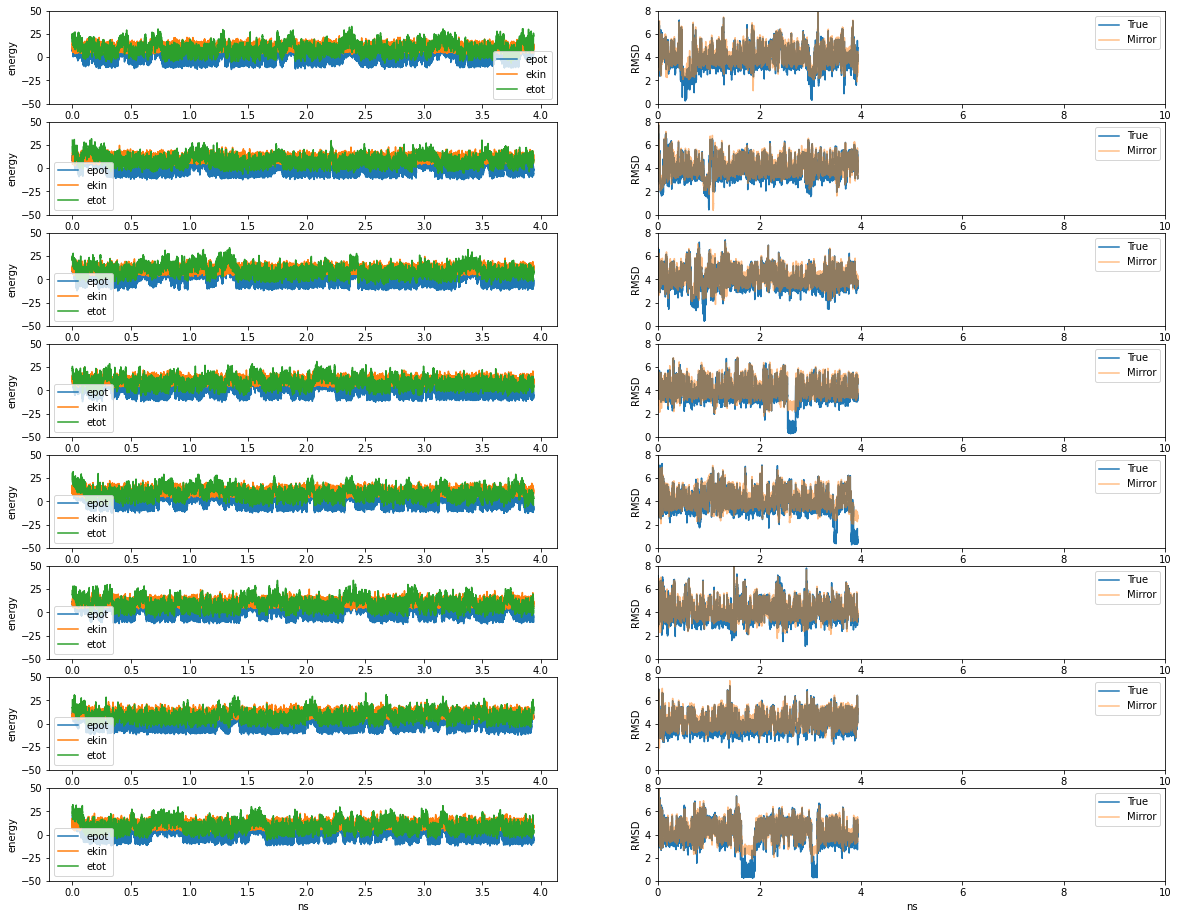

In [4]:
out_dir = '../simulations/CLN/NN_pretrained_cln/'
ts = 0.0001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

## Plot simulation with NN trained on cln retrained

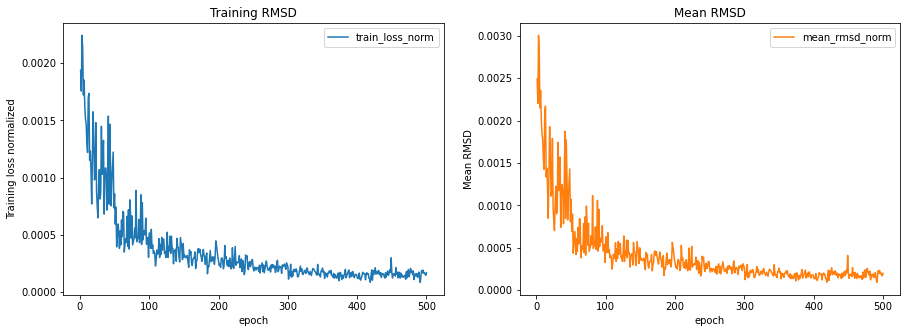

In [5]:
monitor_retrained_cln = '../trainings/Train_clnNN/cln_precln/monitor.csv'
plot_training(monitor_retrained_cln)

###  8 conformation

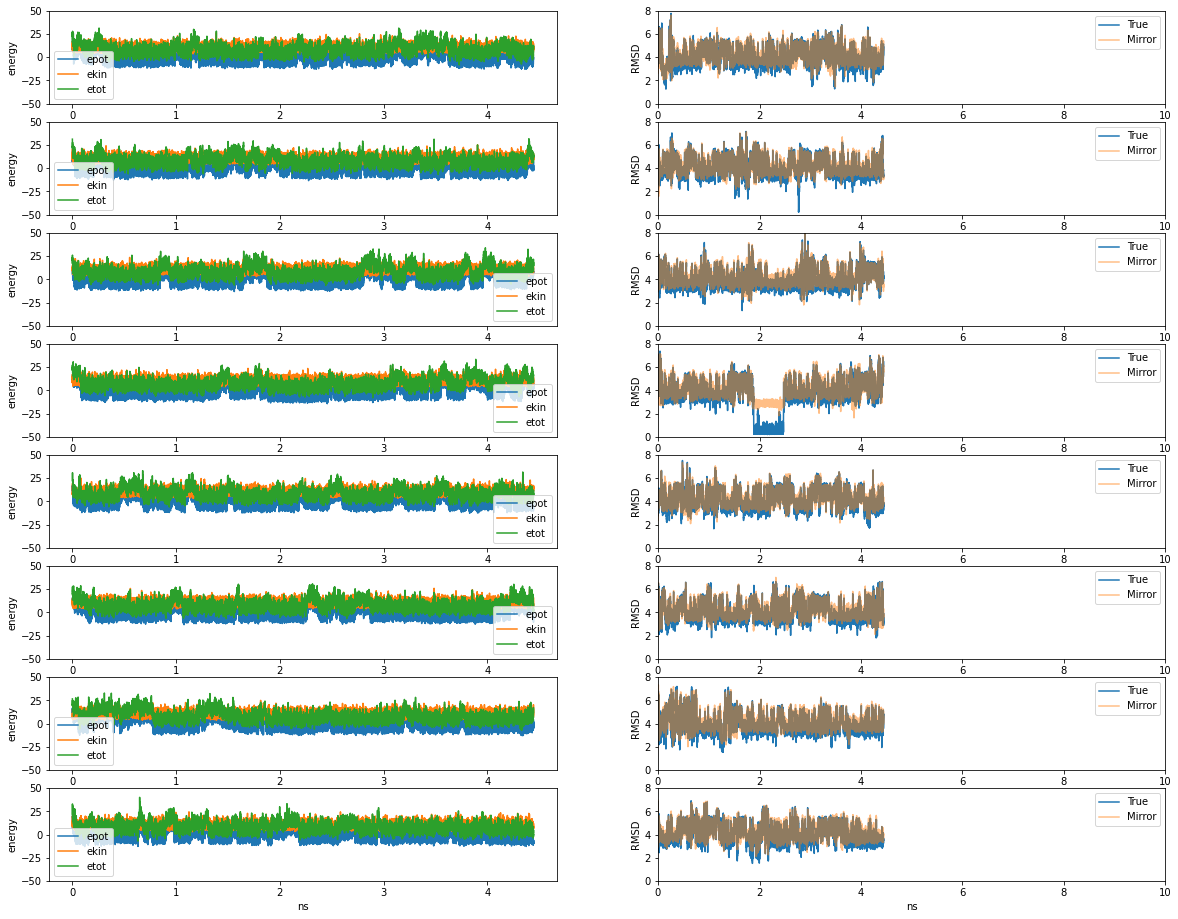

In [6]:
out_dir = '../simulations/CLN/NN_pretrained_cln_retrained/'
ts = 0.0001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10
          )

### 10 conformations

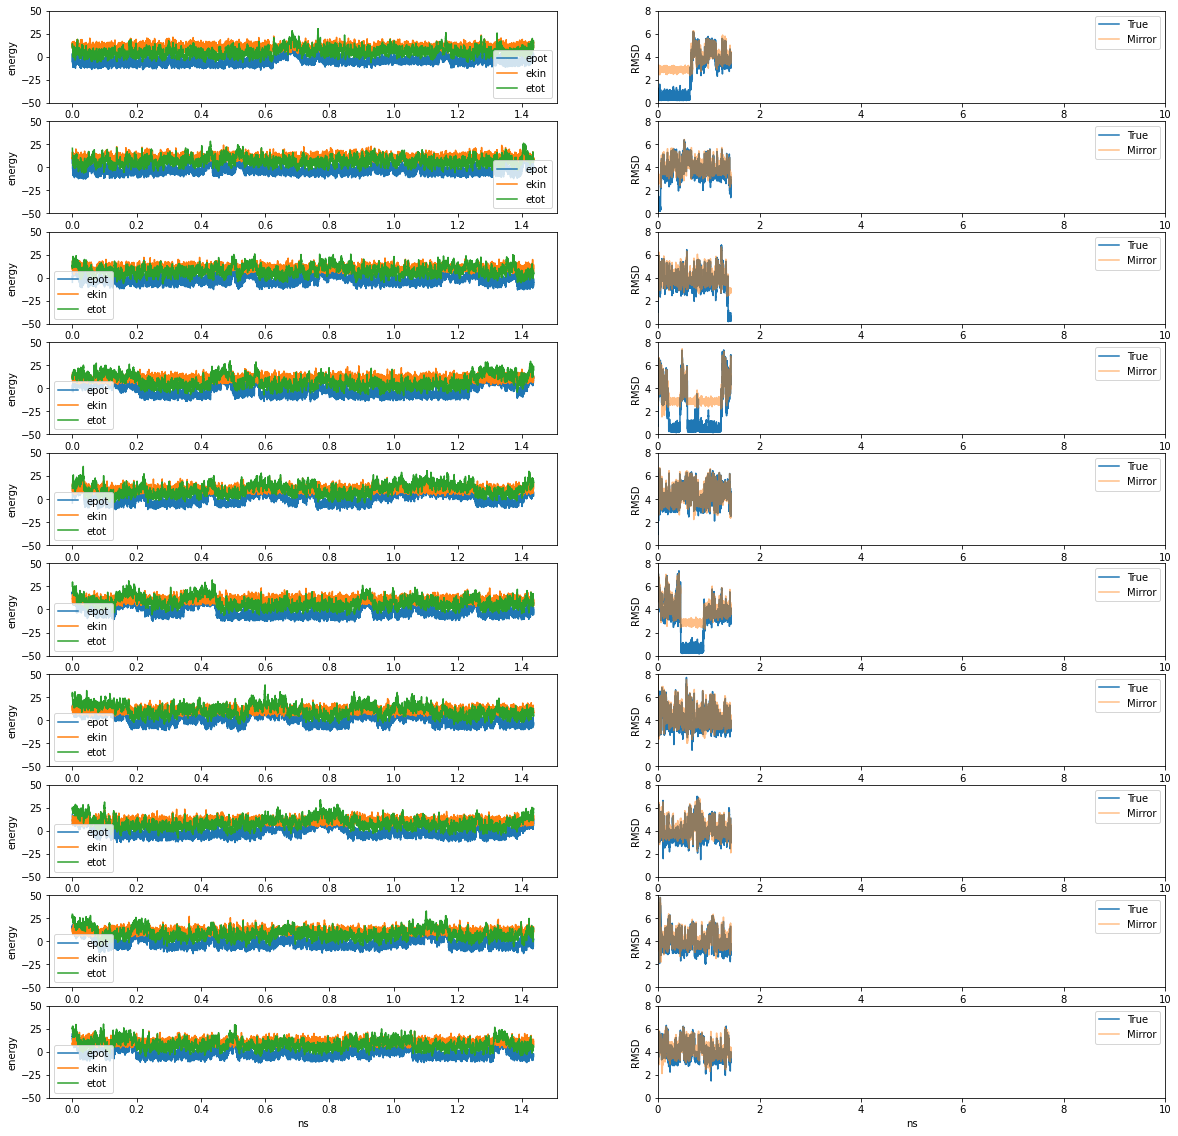

In [7]:
out_dir = '../simulations/CLN/NN_pretrained_cln_retrained_10/'
ts = 0.0001 # time step in ns 
n_traj = 10 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

## Plot simulation with NN trained on lambda

Simulation with the neural network that was trained on lambda repressor. Never reaches RMSD < 4. Oscilates less than the NN trained on chingolin.

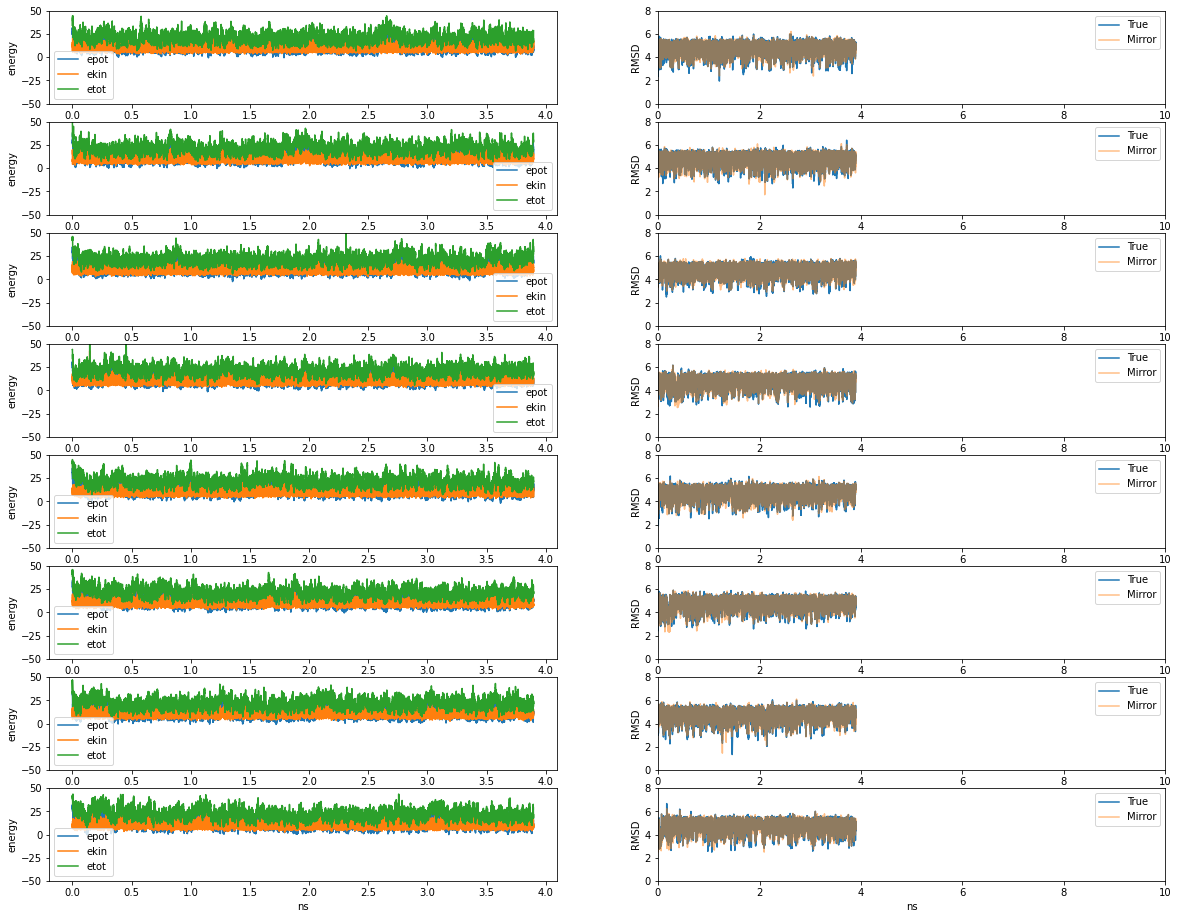

In [8]:
out_dir = '../simulations/CLN/NN_pretrained_lambda'
ts = 0.0001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

## Plot simulation with NN trained on lambda retrained 

This neural network is trained on top of the the network previously trained on lambda repressor, the training has been done using the native conformation as starting point and learning how to keep that conformation stable. We see how for the simulations that start at RMSD ~= 2 can reach the native conformation. However, the conformations that start at RMSD ~= 8 never reach that state.

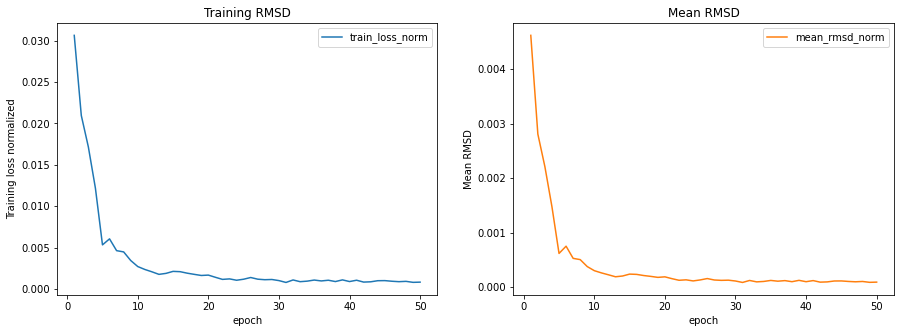

In [53]:
monitor_retrained_lambda = '../trainings/Train_lambdaNN/cln_prelambda_02_09/monitor.csv'
plot_training(monitor_retrained_lambda)

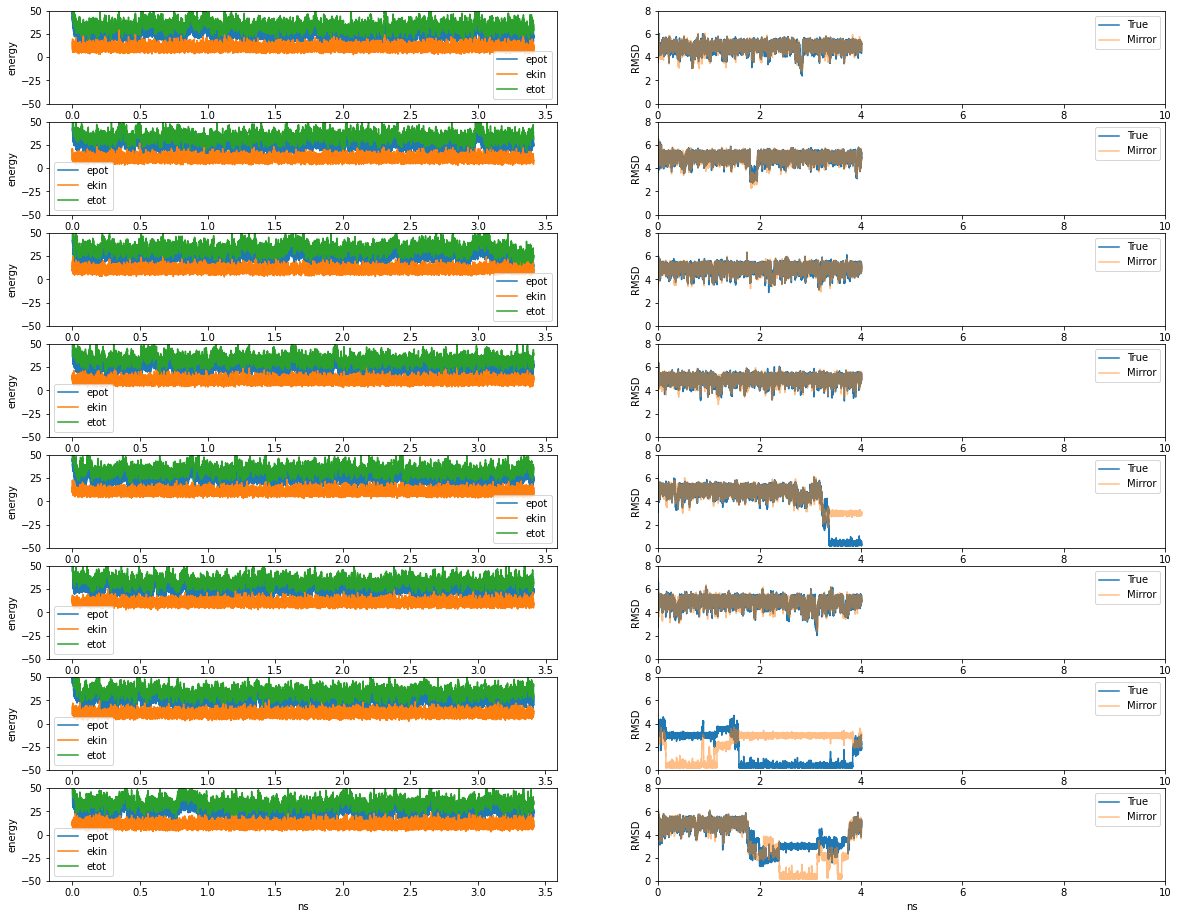

In [10]:
out_dir = '../simulations/CLN/NN_pretrained_lambda_retrain'
ts = 0.0001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

### Training process

## Plot simulation with NN trained from scratch using bonds, repulsioncg and dihedrals

This NN has been trained from scratch to keep the native structure stable, starting with that pdb conformation. Again, if the starting RMSD is close to native it can reach that conformation, but the conformations that start from a higher RMSD never reach the native structure and during the simulation the protein is oscilating more.

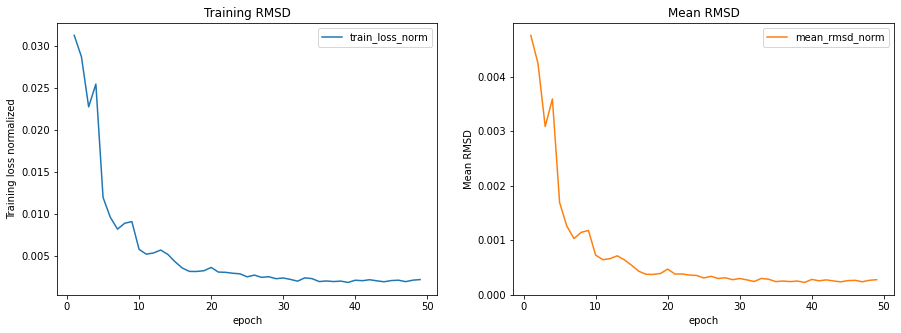

In [11]:
monitor_NN_scratch = '../trainings/Train_NN_scratch/cln_gnn_brd_02_09/monitor.csv'
plot_training(monitor_NN_scratch)

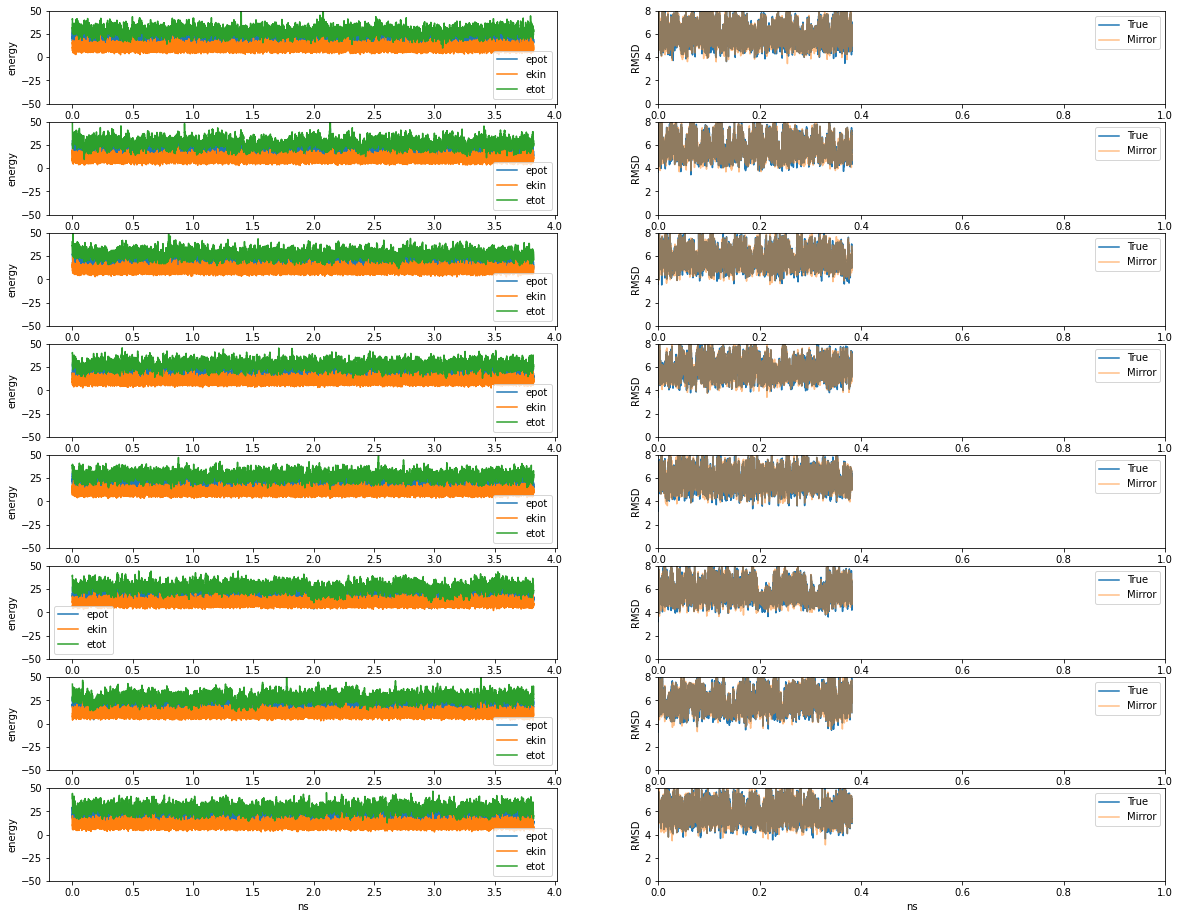

In [12]:
out_dir = '../simulations/CLN/NN_trained_scratch_cln'
ts = 0.00001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 1, ylim = 8)

## Plot simulation of NN trained a folded conformation (RMSD around 2) of chingolin

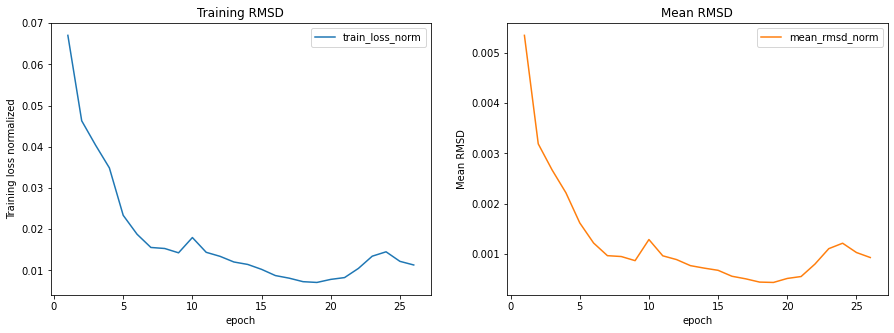

In [13]:
monitor_NN_scratch_5conf = '../trainings/Train_NN_scratch/cln_gnn_brd_02_09_5conf/monitor.csv'
plot_training(monitor_NN_scratch_5conf)

### 8 conformations

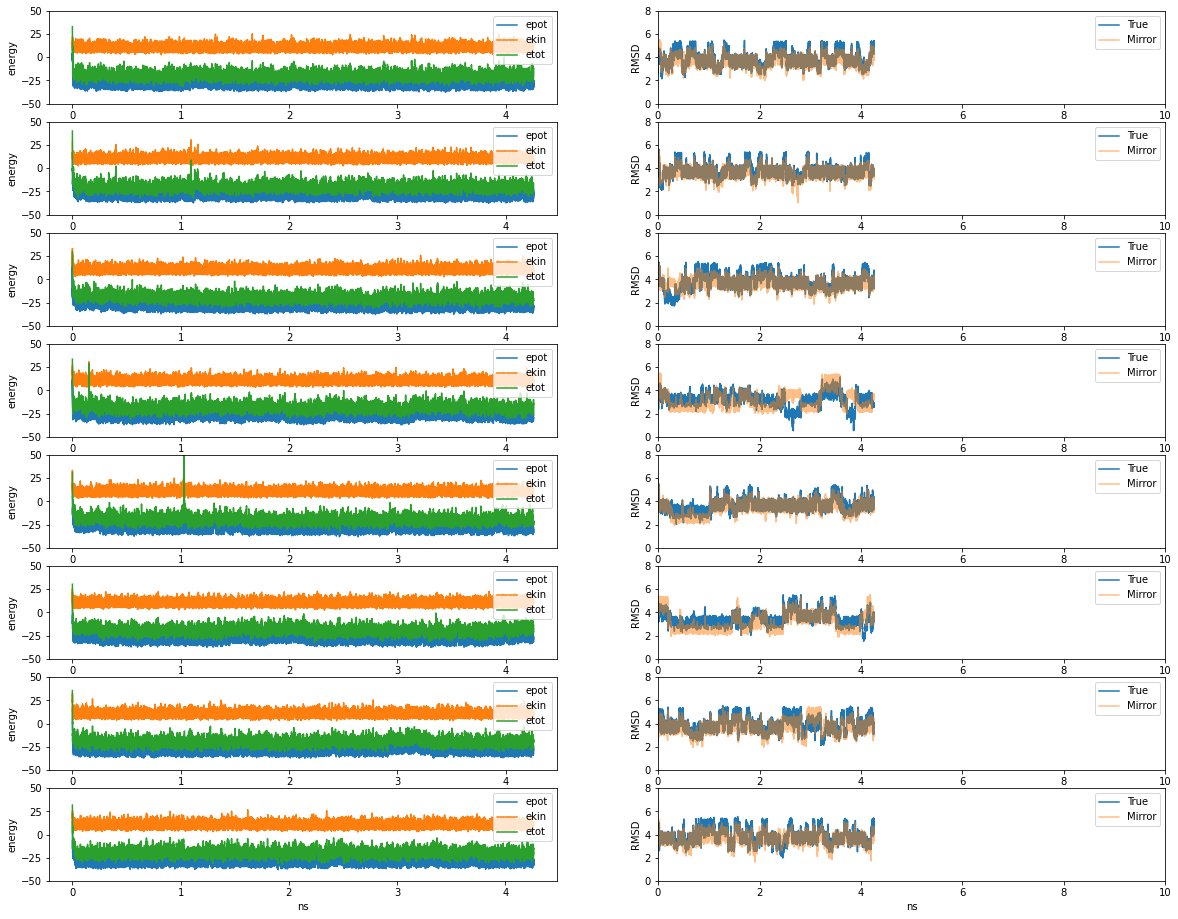

In [14]:
out_dir = '../simulations/CLN/NN_trained_scratch_5conformations'
ts = 0.0001 # time step in ns 
n_traj = 8 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

### 10 conformations

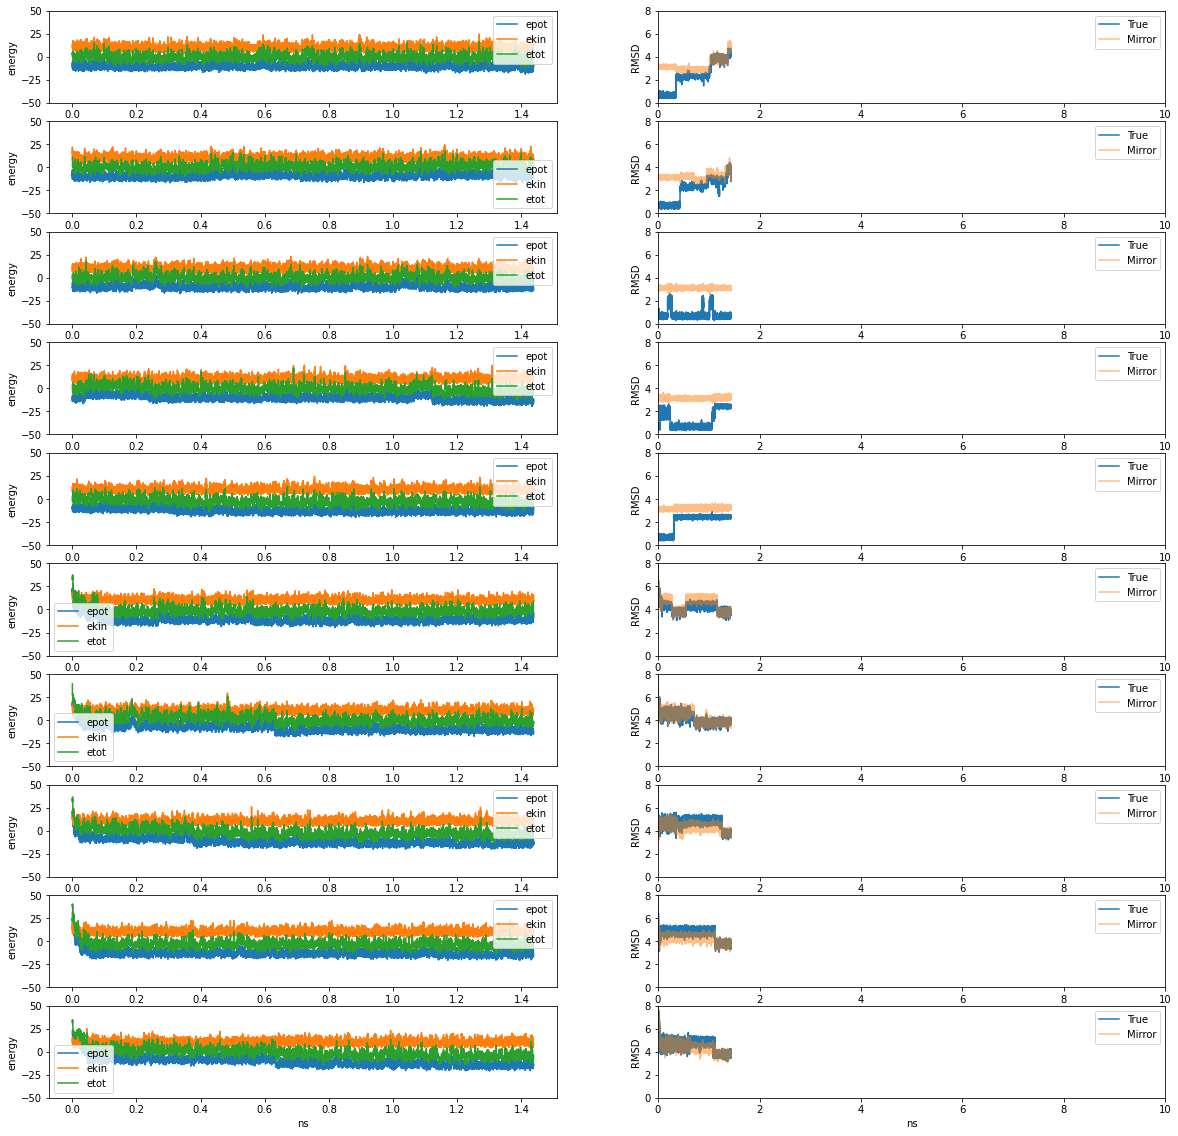

In [15]:
out_dir = '../simulations/CLN/NN_trained_scratch_5conf_10'
ts = 0.0001 # time step in ns 
n_traj = 10 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

## Plot simulation trained on multiple proteins

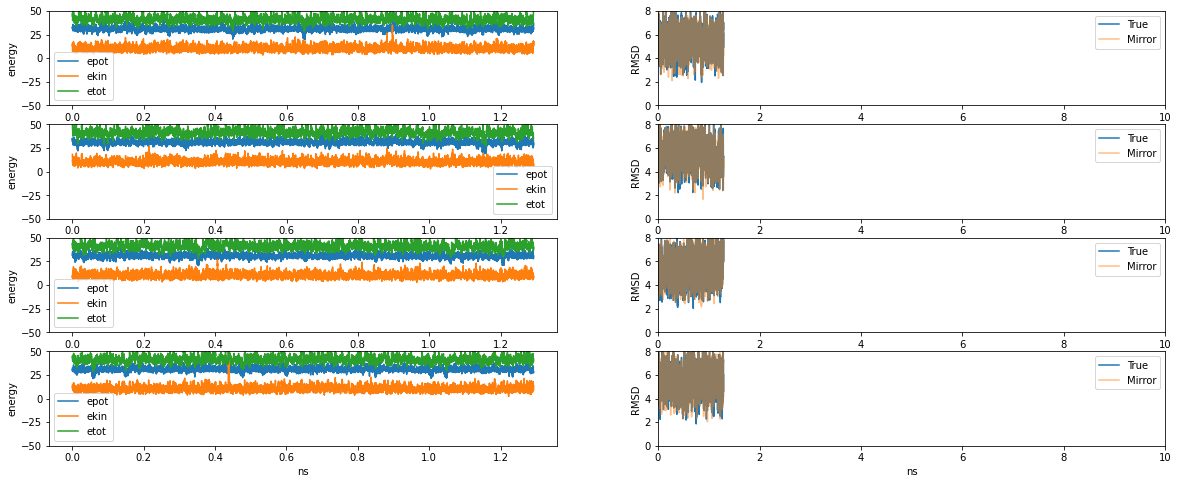

In [16]:
out_dir = '../simulations/CLN/NN_trained_multi'
ts = 0.0001 # time step in ns 
n_traj = 4 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 10)

## Plot simulation with bonds repulsions and dihedrals

Simulation without a NN, using as forceterms bonds, repulsioncg and dihedrals. We see more oscilation of the protein between 4 and 6. 

In [1]:
out_dir = '../data/prev_simulations/sim_cln_noNN_s200k'
ts = 0.0001 # time step in ns 
n_traj = 10 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, xlim = 0)

NameError: name 'plot_trajs' is not defined

## Plot simulation of training a NN from scratch only using repulsions

### Training process

In [ ]:
monitor_NN_repulsions_scratch = '../trainings/cln_gnn_r_02_09_arch2_trainset=50/monitor.csv'
plot_training(monitor_NN_repulsions_scratch)

## Plot simulation with repulsions

Simulation with only repulsioncg. The protein goes far away and the simulation makes no sense, this has been done just to compare this simulation with a simulation with a trained NN and only repulsioncg as forceterms. 

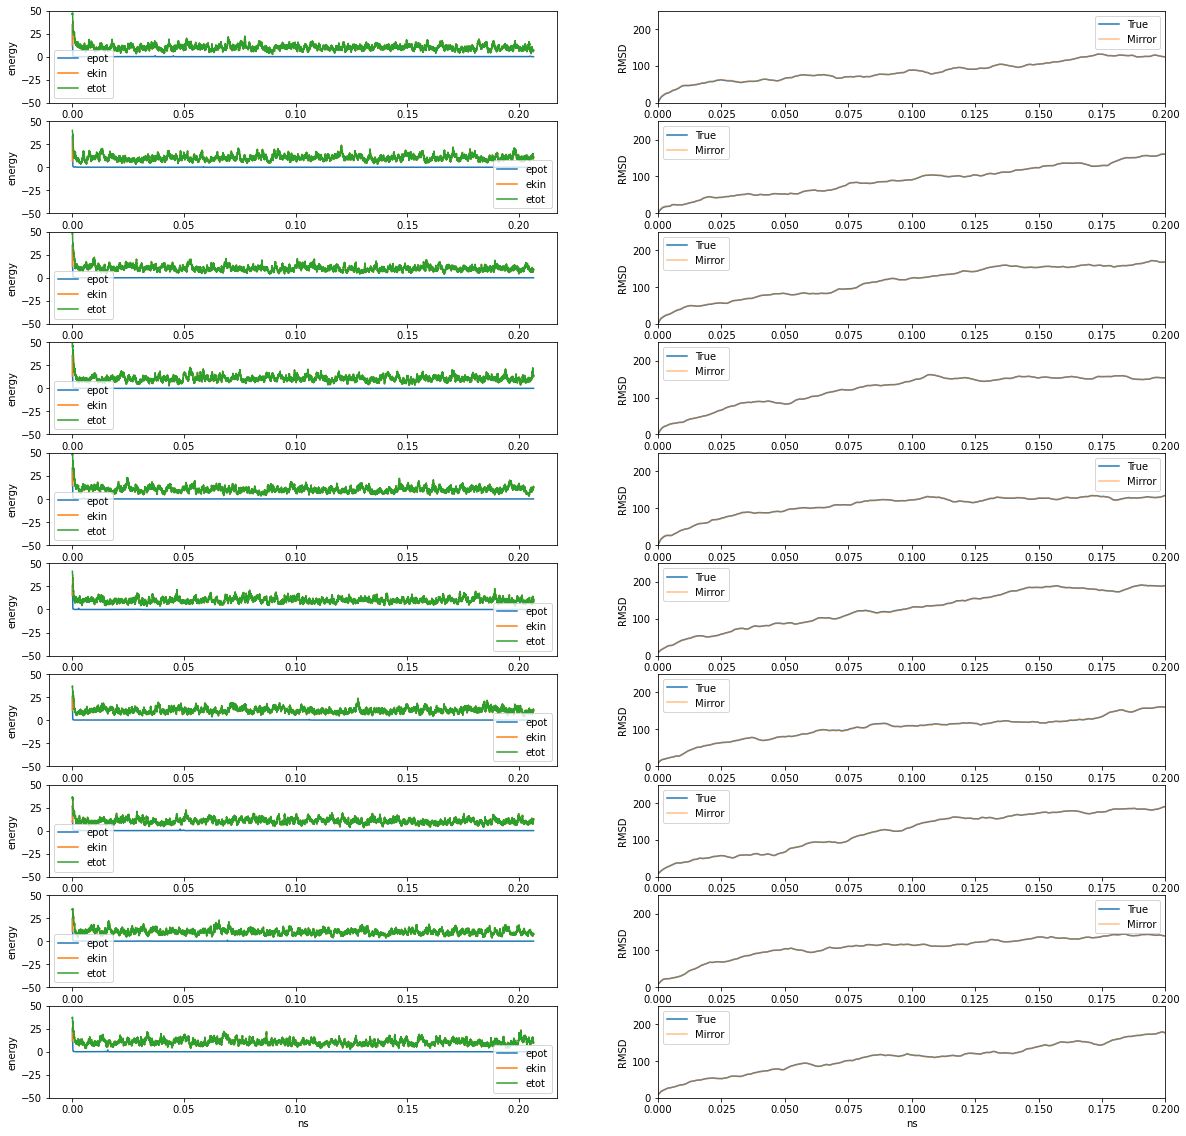

In [18]:
out_dir = '../data/prev_simulations/sim_cln_onlyCG_s200k/'
ts = 0.00001 # time step in ns 
n_traj = 10 # number of trajectories
mol_dir = '../data/chignolin_cln025.psf'

plot_trajs(out_dir, ts, n_traj, mol_dir, ylim = 250, xlim = 0.2)